<a href="https://colab.research.google.com/github/thmswhelan/UCDPA_ThomasWhelan/blob/main/PropertyPricesIreland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [674]:
pip install requests beautifulsoup4

In [675]:
import pandas as pd
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/thmswhelan/UCDPA_ThomasWhelan/main/Property_Price_Register_Ireland-28-05-2021.csv"

df_house = pd.read_csv(url)

url2 = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html"
response = requests.get(url2)

if response.status_code == 200:
    page_content = response.content
    dfs = pd.read_html(page_content)  # Returns a list of DataFrames from HTML tables
    table_df = dfs[0]  # Assuming the first table is the one with the data
    # You might need to adjust the index if the target table is at a different position.
    print("Successful")
else:
    print("Failed to fetch the web page.")

Successful


In [676]:
df_house["SALE_DATE"] = pd.to_datetime(df_house["SALE_DATE"])
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476745 entries, 0 to 476744
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   SALE_DATE           476745 non-null  datetime64[ns]
 1   ADDRESS             476745 non-null  object        
 2   POSTAL_CODE         89764 non-null   object        
 3   COUNTY              476745 non-null  object        
 4   SALE_PRICE          476745 non-null  float64       
 5   IF_MARKET_PRICE     476745 non-null  int64         
 6   IF_VAT_EXCLUDED     476745 non-null  int64         
 7   PROPERTY_DESC       476745 non-null  object        
 8   PROPERTY_SIZE_DESC  52792 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 32.7+ MB


In [677]:
# Create a DataFrame from the provided data
df = pd.DataFrame(table_df)
df.head()

Date (with effect from)                      Deposit facility  \
       Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0                    2023             2 Aug.               3.75   
1                    2023            21 Jun.               3.50   
2                    2023             10 May               3.25   
3                    2023            22 Mar.               3.00   
4                    2023             8 Feb.               2.50   

    Main refinancing operations                                         \
  Fixed rate tenders Fixed rate Variable rate tenders Minimum bid rate   
0                          4.25                                      -   
1                          4.00                                      -   
2                          3.75                                      -   
3                          3.50                                      -   
4                          3.00                                      -   

  Marginal lending facility  
         Unnamed: 5_level_1  
0                      4.50  
1                      4.25  
2                      4.00  
3                      3.75  
4                      3.25

In [678]:
columns_to_drop = ["Deposit facility", "Main refinancing operations"]
df_dropped = df.drop(columns=columns_to_drop)
df_dropped.head()

Date (with effect from)                    Marginal lending facility
       Unnamed: 0_level_1 Unnamed: 1_level_1        Unnamed: 5_level_1
0                    2023             2 Aug.                      4.50
1                    2023            21 Jun.                      4.25
2                    2023             10 May                      4.00
3                    2023            22 Mar.                      3.75
4                    2023             8 Feb.                      3.25

In [679]:
df_keep = pd.DataFrame(df_dropped)

# Flatten the multi-level column headers
df_keep.columns = df_keep.columns.map('_'.join)

# Select the specific columns you want
desired_columns = ["Date (with effect from)_Unnamed: 0_level_1", "Date (with effect from)_Unnamed: 1_level_1", "Marginal lending facility_Unnamed: 5_level_1"]
filtered_df = df_keep[desired_columns]


In [680]:
df_interest= pd.DataFrame(filtered_df)

In [681]:
column_name = 'Date (with effect from)_Unnamed: 1_level_1'
pattern_to_remove = r'\.\d$|\.$|\.\s\d$'  # Regular expression to match ".#" at the end of a string

df_interest[column_name] = df_interest[column_name].str.replace(pattern_to_remove, '')

<ipython-input-681-046c6def6dba>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_interest[column_name] = df_interest[column_name].str.replace(pattern_to_remove, '')


In [682]:
df_interest = df_interest.fillna(method='ffill')

In [683]:
df_interest['Combined']=df_interest['Date (with effect from)_Unnamed: 1_level_1'] + " "+ df_interest['Date (with effect from)_Unnamed: 0_level_1']
df_interest.head()

,Date (with effect from)_Unnamed: 0_level_1,Date (with effect from)_Unnamed: 1_level_1,Marginal lending facility_Unnamed: 5_level_1,Combined
0,2023,2 Aug,4.50,2 Aug 2023
1,2023,21 Jun,4.25,21 Jun 2023
2,2023,10 May,4.00,10 May 2023
3,2023,22 Mar,3.75,22 Mar 2023
4,2023,8 Feb,3.25,8 Feb 2023


In [684]:
columns_to_drop = ['Date (with effect from)_Unnamed: 0_level_1', 'Date (with effect from)_Unnamed: 1_level_1']
df_dropped = df_interest.drop(columns=columns_to_drop)

In [685]:
df_dropped.rename(columns={'Marginal lending facility_Unnamed: 5_level_1': 'ECB_INTEREST_RATE'}, inplace=True)
df_dropped.rename(columns={'Combined': 'DATE_INTEREST_RATE'}, inplace=True)
df_dropped.head()

,ECB_INTEREST_RATE,DATE_INTEREST_RATE
0,4.50,2 Aug 2023
1,4.25,21 Jun 2023
2,4.00,10 May 2023
3,3.75,22 Mar 2023
4,3.25,8 Feb 2023


In [686]:
df_dropped.dtypes

ECB_INTEREST_RATE     object
DATE_INTEREST_RATE    object
dtype: object

In [687]:
df_interest_rate = df_dropped.drop(index=df_dropped.index[-2:])

In [688]:
df_interest_rate['ECB_INTEREST_RATE'] = df_interest_rate['ECB_INTEREST_RATE'].astype(float)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ECB_INTEREST_RATE   58 non-null     float64
 1   DATE_INTEREST_RATE  58 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [689]:
column_name = 'DATE_INTEREST_RATE'
date_format = '%d %b %Y'  # Format to match "2 Aug 2023"

df_interest_rate[column_name] = pd.to_datetime(df_interest_rate[column_name], format=date_format)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ECB_INTEREST_RATE   58 non-null     float64       
 1   DATE_INTEREST_RATE  58 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [690]:
min_date = df_house['SALE_DATE'].min()
max_date = df_house['SALE_DATE'].max()
print(min_date)
print(max_date)

2010-01-01 00:00:00
2021-05-28 00:00:00


In [691]:
start_date = pd.to_datetime('2009-05-12')
end_date = pd.to_datetime('2022-07-31')

df_interest_rate = df_interest_rate[(df_interest_rate['DATE_INTEREST_RATE'] >= start_date) & (df_interest_rate['DATE_INTEREST_RATE'] <= end_date)]

print(df_interest_rate)

    ECB_INTEREST_RATE DATE_INTEREST_RATE
8                0.75         2022-07-27
9                0.25         2019-09-18
10               0.25         2016-03-16
11               0.30         2015-12-09
12               0.30         2014-09-10
13               0.40         2014-06-11
14               0.75         2013-11-13
15               1.00         2013-05-08
16               1.50         2012-07-11
17               1.75         2011-12-14
18               2.00         2011-11-09
19               2.25         2011-07-13
20               2.00         2011-04-13
21               1.75         2009-05-13


In [692]:
df_house['month_year'] = df_house['SALE_DATE'].dt.to_period('M')
df_interest_rate['month_year'] = df_interest_rate['DATE_INTEREST_RATE'].dt.to_period('M')

In [693]:
# Calculate monthly mean and median prices
monthly_mean_prices = df_house.groupby('month_year')['SALE_PRICE'].mean()
monthly_median_prices = df_house.groupby('month_year')['SALE_PRICE'].median()

# Create a DataFrame for monthly median prices
monthly_stats = pd.DataFrame({'month_year': monthly_median_prices.index, 'median_price': monthly_median_prices.values,'mean_price': monthly_mean_prices.values})

# Concatenate the two DataFrames
monthly_stats_df = pd.concat([headers_df, monthly_stats], axis=1)
monthly_stats_df.drop(columns=['Month_Year','Median_Price'], inplace=True)
# Print information about the resulting DataFrame
print(monthly_stats_df.info())

# Display the resulting DataFrame
print(monthly_stats_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 0 to 136
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   month_year    137 non-null    period[M]
 1   median_price  137 non-null    float64  
 2   mean_price    137 non-null    float64  
dtypes: float64(2), period[M](1)
memory usage: 4.3+ KB
None
  month_year  median_price     mean_price
0    2010-01    220263.420  262482.281768
1    2010-02    216000.000  262360.086718
2    2010-03    210000.000  247859.892452
3    2010-04    211453.365  245323.651606
4    2010-05    203772.200  237789.409767


In [697]:
monthly_stats_df['month_year_timestamp'] = monthly_stats_df['month_year'].astype(str)
monthly_stats_df['month_year_timestamp'] = pd.to_datetime(monthly_stats_df['month_year_timestamp'])

monthly_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 0 to 136
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   month_year            137 non-null    period[M]     
 1   median_price          137 non-null    float64       
 2   mean_price            137 non-null    float64       
 3   month_year_timestamp  137 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), period[M](1)
memory usage: 5.4+ KB


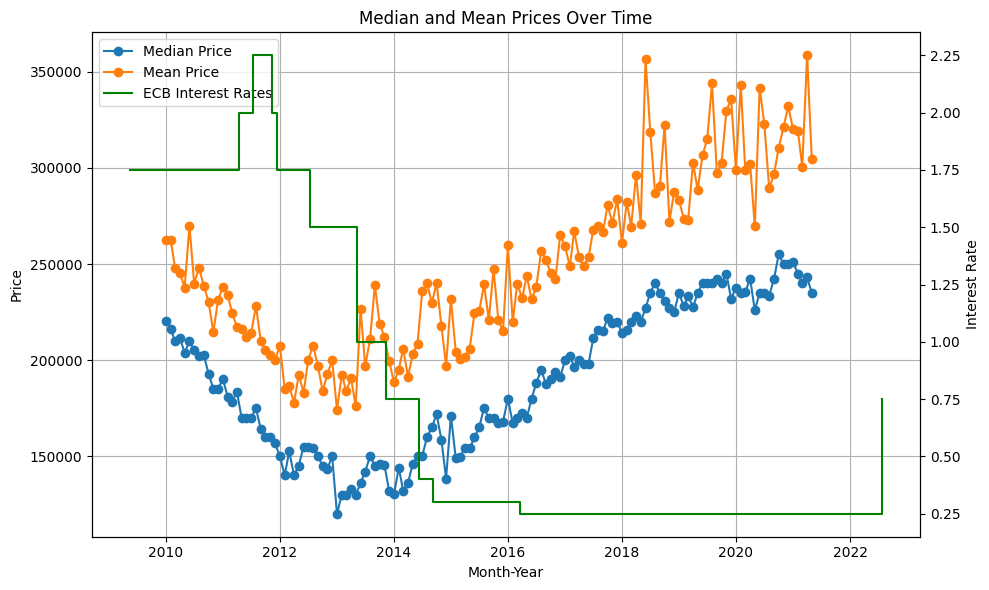

In [699]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_stats_df['month_year_timestamp'], monthly_stats_df['median_price'], marker='o', label='Median Price')
plt.plot(monthly_stats_df['month_year_timestamp'], monthly_stats_df['mean_price'], marker='o', label='Mean Price')
plt.title('Median and Mean Prices Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Create a secondary y-axis for the second plot
ax1 = plt.gca()  # Get the current axes
ax2 = ax1.twinx()  # Create a twin axes sharing the x-axis
ax2.step(df_interest_rate['DATE_INTEREST_RATE'], df_interest_rate['ECB_INTEREST_RATE'], color='green', where='pre', label='ECB Interest Rates')
ax2.set_ylabel('Interest Rate')

# Combine legends from both plots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(df['month_year'], df['median_price'], marker='o', label='Median Price')
plt.plot(df['month_year'], df['mean_price'], marker='o', label='Mean Price')
plt.title('Median and Mean Prices Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Create a secondary y-axis for the second plot
ax1 = plt.gca()  # Get the current axes
ax2 = ax1.twinx()  # Create a twin axes sharing the x-axis
ax2.step(df_interest_rate['DATE_INTEREST_RATE'], df_interest_rate['ECB_INTEREST_RATE'], color='green', where='pre', label='ECB Interest Rates')
ax2.set_ylabel('Interest Rate')

# Combine legends from both plots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Sort DataFrames by date columns
df_house.sort_values(by='SALE_DATE', inplace=True)
df_interest_rate.sort_values(by='DATE_INTEREST_RATE', inplace=True)

# Forward fill missing values in interest rate DataFrame
df_interest_rate['ECB_INTEREST_RATE'].ffill(inplace=True)

# Merge DataFrames
merged_df = pd.merge_asof(df_house, df_interest_rate, left_on='SALE_DATE', right_on='DATE_INTEREST_RATE', direction='backward')

# Drop unnecessary columns
merged_df.drop(columns='DATE_INTEREST_RATE', inplace=True)

# Fill forward the ECB_INTEREST_RATE column in the merged DataFrame
merged_df['ECB_INTEREST_RATE'].ffill(inplace=True)

# Display the updated DataFrame
merged_df.head()

In [ ]:
merged_df.tail()

In [ ]:
columns_to_drop = ['POSTAL_CODE', 'IF_MARKET_PRICE','IF_VAT_EXCLUDED','PROPERTY_SIZE_DESC','month_year_y']
merged_df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
merged_df.head()

In [ ]:
merged_df['year'] = df_house['SALE_DATE'].dt.year
merged_df.head()

In [ ]:
print(merged_df['COUNTY'].unique())
print(merged_df['PROPERTY_DESC'].unique())

In [ ]:
# Define the replacement values and corresponding unique values to be replaced
replacement_mapping = {
    'Second-Hand Dwelling house /Apartment': 'Second Hand',
    'Teach/�ras�n C�naithe Ath�imhe': 'Second Hand',  # Updated with correct encoded value
    'New Dwelling house /Apartment': 'New',
    'Teach/�ras�n C�naithe Nua': 'New',
    'Teach/?ras?n C?naithe Nua': 'New'  # Updated with correct encoded value
}

# Replace values in the 'PROPERTY_DESC' column using the mapping
merged_df['PROPERTY_DESC'] = merged_df['PROPERTY_DESC'].replace(replacement_mapping)
print(merged_df['PROPERTY_DESC'].unique())

In [ ]:
import seaborn as sns

In [ ]:
# Create a boxplot with outliers removed
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='SALE_PRICE', data=merged_df, showfliers=False)
plt.title('Boxplot by Year (Outliers Removed)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def county_boxplot(county_name):
    county_data = merged_df[merged_df['COUNTY'] == county_name]

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='year', y='SALE_PRICE', data=county_data, showfliers=False)
    plt.title(f'Boxplot for {county_name} (Outliers Removed)')
    plt.xlabel('Year')
    plt.ylabel('Sale Price')
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# Call the function with a specific county name
county_boxplot('Leitrim')

In [ ]:
# Sort the data by the count of each category
sorted_df = merged_df['COUNTY'].value_counts().reset_index()
sorted_df.columns = ['COUNTY', 'COUNT']

# Create the histogram plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=sorted_df, x='COUNTY', y='COUNT')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.xlabel('County')
plt.ylabel('Count')
plt.title('Distribution of Counties')
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

In [ ]:
sns.heatmap(merged_df.corr(),annot = True)
plt.show()

In [ ]:
start_date = pd.to_datetime('2009-04-14')
end_date = pd.to_datetime('2022-08-01')

# Generate a list of all months between start_date and end_date
date_range = pd.date_range(start_date, end_date, freq='MS')

# Convert the date_range to a DataFrame with a 'month_year' column
df_month_year = pd.DataFrame({'month_year': date_range})

# Convert 'month_year' to string to match the format in df_interest_rate
df_month_year['month_year'] = df_month_year['month_year'].dt.strftime('%Y-%m')

# Merge the new DataFrame with the existing df_interest_rate DataFrame based on 'month_year'
df_interest_rate = pd.merge(df_interest_rate, df_month_year, left_on=df_interest_rate['DATE_INTEREST_RATE'].dt.strftime('%Y-%m'), right_on='month_year', how='right')

# Drop the extra columns introduced by the merge
df_interest_rate.drop(columns=['month_year_y'], inplace=True)
df_interest_rate.drop(columns=['month_year_x'], inplace=True)
df_interest_rate.drop(columns=['DATE_INTEREST_RATE'], inplace=True)

df_interest_rate['ECB_INTEREST_RATE'] = df_interest_rate['ECB_INTEREST_RATE'].fillna(method='ffill')

# Print the updated DataFrame
print(df_interest_rate)
df_interest_rate.dtypes

In [ ]:
df_interest_rate['month_year'] = pd.to_datetime(df_interest_rate['month_year'])
monthly_median_prices['month_year'] = pd.to_datetime(monthly_median_prices['month_year'])
df_interest_rate['month_year'] = df_interest_rate['month_year'].dt.to_period('M')
monthly_median_prices['month_year'] = monthly_median_prices['month_year'].dt.to_period('M')
print(df_interest_rate)
df_interest_rate.dtypes
print(monthly_median_prices)
monthly_median_prices.dtypes

In [ ]:
merged_median_interest_df = pd.merge(df_interest_rate, monthly_median_prices,on='month_year', how='right')
print(merged_median_interest_df)